# CNN Architectures (LeNet, AlexNet, VGGNet)

Tutorial reference, further reading and practice: Dive into Deep Learning (https://d2l.ai/)
    
We will discuss about the implementation of various basic CNN structures like LeNet, AlexNet, an architecture similar to VGGNet; compare the performances and dive a little into understanding/interpreting the results.

For this practical the training will take longer time - may be hours depending on your computer hardware. GPU access will speed up the process. It is recommended you use Google colab
https://colab.research.google.com/

For this tutorial, we’ll use some in-built functions of the book. To do so, install the following using your Anaconda command prompt.

In [ ]:
# -U: Upgrade all packages to the newest available version
!pip install d2l==0.16.2

# Fashion MNIST Image Classification Dataset


One of the widely used dataset for image classification is the MNIST dataset [LeCun et al., 1998].
While it had a good run as a benchmark dataset, even simple models by today’s standards achieve
classification accuracy over 95%, making it unsuitable for distinguishing between stronger models
and weaker ones. Today, MNIST serves as more of sanity checks than as a benchmark. To up the
ante just a bit, we will focus our discussion in the coming sections on the qualitatively similar, but
comparatively complex Fashion-MNIST dataset [Xiao et al., 2017], which was released in 2017.

# Import Libraries 

In [ ]:
from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, MaxPooling2D, Dropout, concatenate, UpSampling2D,ZeroPadding2D, Flatten, Dense
from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K
import tensorflow as tf

from requests import get
from d2l import tensorflow as d2l
d2l.use_svg_display()

In [ ]:
import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import gc


## Reading the Datase

We can download and read the Fashion-MNIST dataset into memory via the build-in functions in
the framework.

In [ ]:
from keras.datasets import fashion_mnist
from matplotlib import pyplot as plt

# load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Fashion-MNIST consists of images from 10 categories, each represented by 6000 images in the
training dataset and by 1000 in the test dataset. A test dataset (or test set) is used for evaluating
model performance and not for training. 


In [ ]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))



The height and width of each input image are both 28 pixels. Note that the dataset consists of
grayscale images, whose number of channels is 1. For brevity, throughout this book we store the
shape of any image with height h width w pixels as $h$ × $w$ or ($h$,$w$).

In [ ]:
def display_image(position):
    image = X_trian[position].squeeze()
    plt.title('Example %d. Label: %d' % (position,  y_train[position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

The images in Fashion-MNIST are associated with the following categories: t-shirt, trousers,
pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot. The following function converts
between numeric label indices and their names in text.

In [ ]:
def get_fashion_mnist_labels(labels): 
  """Return text labels for the Fashion-MNIST dataset."""
  text_labels = [
  't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
  'sneaker', 'bag', 'ankle boot']
  return [text_labels[int(i)] for i in labels]

We can now create a function to visualize these examples.

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): 
  """Plot a list of images."""
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    ax.imshow(img.numpy())
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles:
      ax.set_title(titles[i])
  return axes

Here are the images and their corresponding labels (in text) for the first few examples in the training
dataset

In [ ]:
X = tf.constant(X_train[:16])
y = tf.constant(y_train[:16])
show_images(X, 2, 8, titles=get_fashion_mnist_labels(y));

## Prepare Pixel Data

The pixels are gray scale, i.e., the values are between 0-255. As we do not know yet the best way to scale the values for modelling, we’ll normalise it between 0-1.

In [ ]:
X_train = X_train.reshape((-1, 28, 28, 1)).astype('float32')
X_test = X_test.reshape((-1, 28, 28, 1)).astype('float32')
# one hot encode target values
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# normalize to range 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0
# return normalized images
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)    

##  Reading a Minibatch

To make our life easier when reading from the training and test sets, we use the built-in data
iterator rather than creating one from scratch. Recall that at each iteration, a data loader reads a
minibatch of data with size batch_size each time. We also randomly shuffle the examples for the
training data iterator.

In [ ]:
batch_size = 256
train_iter = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size).shuffle(len(X_train[0]))

Let us look at the time it takes to read the training data

In [ ]:
timer = d2l.Timer()
for X in train_iter:
    continue
f'{timer.stop():.2f} sec'

##  Experiment with various CNN architectures

###  LeNet

At a high level, LeNet (LeNet-5) consists of two parts: (i) a convolutional encoder consisting of
two convolutional layers; and (ii) a dense block consisting of three fully-connected layers; The
architecture is summarized below

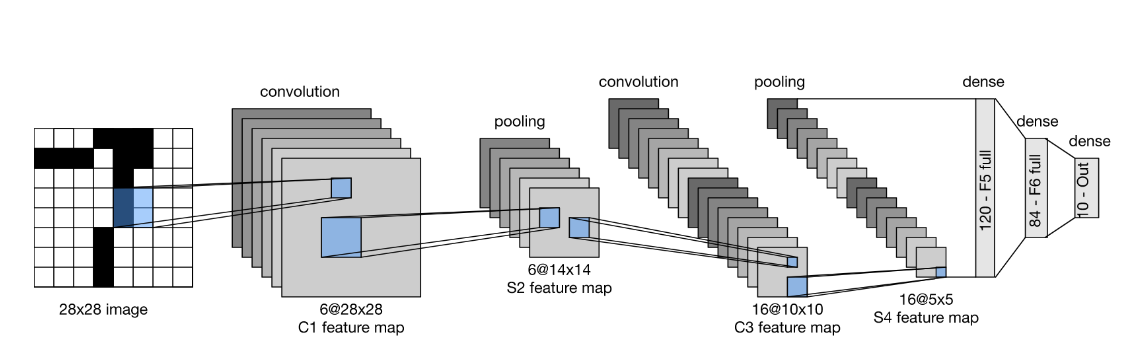

In [ ]:
# define cnn model
def LeNet():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)))
    model.add(layers.AveragePooling2D((2,2), strides=2))
    model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
    model.add(layers.AveragePooling2D((2,2), strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=120, activation='relu'))
    model.add(layers.Dense(units=84, activation='relu'))
    model.add(layers.Dense(units=10, activation = 'softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

By passing a single-channel (black and white) 28×28 image through the network and printing the
output shape at each layer, we can inspect the model to make sure that its operations line up with
what we expect from the following figure

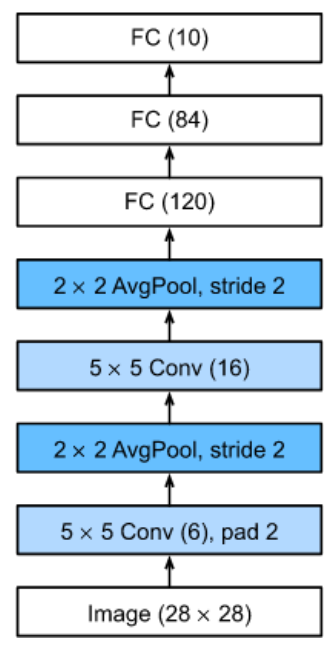

We will start with LeNet model. LeNet model was developed to recognize black and white hand written digits. But here are a few things we need to aware:

First, the original paper proposed the use of ‘sigmoid’ and ‘tanh’ non linearity functions. Second, the non-linearity was applied after the Average Pooling layer not after the convolutional layer. And last, it used a ‘sigmoid’ function at the output layer as a non-linearity function.

We will make slight changes to that. First being, using ‘ReLu’ non-linearity after the convolution layer. And Second, we use the ‘softmax’ activation function at the output layer.

### AlexNet

The design philosophies of AlexNet and LeNet are very similar, but there are also significant
differences. First, AlexNet is much deeper than the comparatively small LeNet. AlexNet consists
of eight layers: five convolutional layers, two fully-connected hidden layers, and one fully-connected
output layer. Second, AlexNet used the ReLU instead of the sigmoid as its activation function.

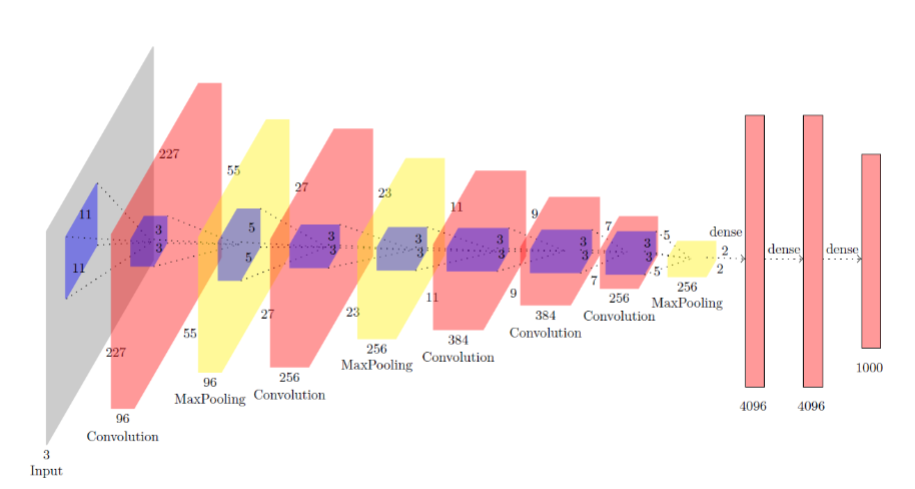

In [ ]:
# define cnn model
def AlexNet():
    model=keras.Sequential()
    model.add(Input((28,28,1)))
    
   #Here, the number of output channels is much larger than that in LeNet
    model.add(Conv2D(96, (3,3), strides=1, activation='relu')) 
    model.add(MaxPool2D((3,3), strides=2))
    # Make the convolution window smaller, set padding to 2 for consistent
    # height and width across the input and output, and increase the
    # number of output channels
    model.add(Conv2D(256, (5,5), padding='same',activation='relu'))
    model.add(MaxPool2D((3,3), strides=2))
    # Use three successive convolutional layers and a smaller convolution
    # window. Except for the final convolutional layer, the number of 
    # output channels is further increased. Pooling layers are not used to
    # reduce the height and width of input after the first two  convolutional layers
    model.add(Conv2D(384, (3,3), padding='same',activation='relu'))
    model.add(Conv2D(384, (3,3), padding='same',activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same',activation='relu'))
    model.add(MaxPool2D((3,3), strides=2))
    model.add(Flatten())
    # Here, the number of outputs of the fully-connected layer is several  
    #times larger than that in LeNet. Use the dropout layer to mitigate overfitting
    model.add(Dense(4096, activation="relu"))
    tf.keras.layers.Dropout(0.5),
    model.add(Dense(4096, activation="relu"))
    tf.keras.layers.Dropout(0.5),
    model.add(Dense(10, activation="softmax"))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In the traditional computer vision algorithms, the most important part of the pipeline was the
representation. In deep learning the architecture itself learns the features. Interestingly in the
lowest layers of the network, the model learned feature extractors that resembled some traditional
filters. AlexNet [Krizhevsky et al., 2012] infact learns and describes lower-level image descriptors
which resembles features that are extracted through traditional filters in the usual computer vision
pipeline.

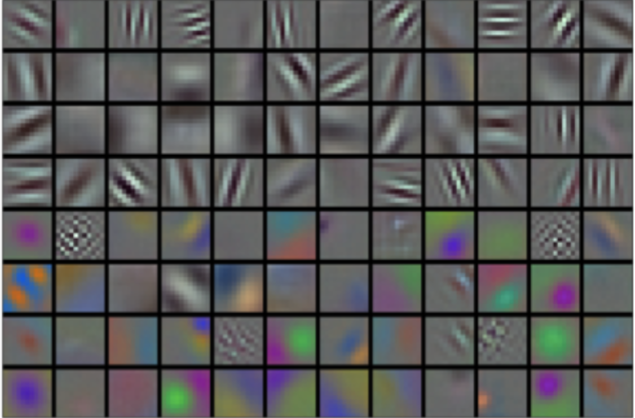

###  VGGNet

VGGNet will take even longer than AlexNet as the depth of the network increases and size of the
filters are larger.

The basic building block of classic CNNs is a sequence of the following: (i) a convolutional layer
with padding to maintain the resolution, (ii) a nonlinearity such as a ReLU, (iii) a pooling layer such
as a max pooling layer. One VGG block consists of a sequence of convolutional layers, followed by
a max pooling layer for spatial downsampling. In the original VGG paper [Simonyan & Zisserman,
2014], the authors employed convolutions with 3 × 3 kernels with padding of 1 (keeping height and
width) and 2 × 2 max pooling with stride of 2 (halving the resolution after each block). 

Like AlexNet and LeNet, the VGG Network can be partitioned into two parts: the first consisting
mostly of convolutional and pooling layers and the second consisting of fully-connected layers.




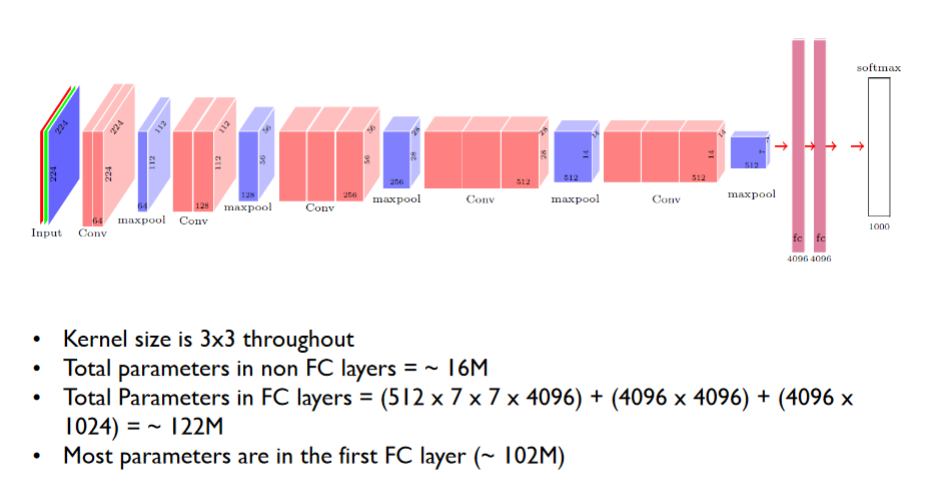

In [ ]:
def VGGNet():
    model=keras.Sequential()
    model.add(Input((28,28,1)))
    model.add(ZeroPadding2D((2,2)))
    model.add(Conv2D(64, (3,3), strides=1, padding='same',activation='relu'))
    model.add(Conv2D(64, (3,3), strides=1, padding='same',activation='relu'))
    model.add(MaxPool2D((2,2), strides=2))
    model.add(Conv2D(128, (3,3), strides=1, padding='same',activation='relu'))
    model.add(Conv2D(128, (3,3), strides=1, padding='same',activation='relu'))
    model.add(MaxPool2D((2,2), strides=2))
    model.add(Conv2D(256, (3,3), strides=1, padding='same',activation='relu'))
    model.add(Conv2D(256, (3,3), strides=1, padding='same',activation='relu'))
    model.add(Conv2D(256, (3,3), strides=1, padding='same',activation='relu'))
    model.add(MaxPool2D((2,2), strides=2))
    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9) #or 
    #opt=Adam()
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model



## Choose your CNN model


In [ ]:
#choose your model
CNNmodel="AlexNet"
#CNNmodel='AlexNet'
#CNNmodel="VGG15"
if CNNmodel=="LeNet":
    model = LeNet()
elif CNNmodel=="AlexNet":
    model = AlexNet()
elif CNNmodel=="VGGNet":
    model = VGGNet()  
model.summary()
    

In [ ]:
#!pip install visualkeras
import visualkeras
visualkeras.layered_view(model)

##  Training and Evaluation

Now that we have implemented the model, let us run an experiment to see how LeNet fares on
Fashion-MNIST

Since we will be implementing networks with many layers going forward, we will rely primarily on high-level APIs. The following training function assumes a model created from high-level APIs as input and is optimized accordingly. We initialize the model parameters on the device indicated by the device argument, using Xavier initialization https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html#subsec-xavier (the chapter is also useful to read generally about various initialisations in MLPs). Just as with MLPs (and in the previous lab), our loss function is cross-entropy, and we minimize it via minibatch stochastic gradient descent. Since each epoch takes tens of seconds to run, we visualize the training loss more frequently.

In [ ]:
if CNNmodel=="LeNet":
    callbacks = [EarlyStopping(patience=10, verbose=1),
      ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
      ModelCheckpoint('model-LeNet.h5', verbose=1, save_best_only=True, save_weights_only=True),
      TensorBoard(log_dir='./logs')]
elif CNNmodel=="AlexNet":
    callbacks = [EarlyStopping(patience=10, verbose=1),
      ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
      ModelCheckpoint('model-AlexNet.h5', verbose=1, save_best_only=True, save_weights_only=True),
      TensorBoard(log_dir='./logs')]
elif CNNmodel=="VGGNet":
    callbacks = [EarlyStopping(patience=10, verbose=1),
      ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
      ModelCheckpoint('model-VGGNet.h5', verbose=1, save_best_only=True, save_weights_only=True),
      TensorBoard(log_dir='./logs')]


Now that we have chosen the model and we have set up the tuning paramters, let us train the model.

In [ ]:
EPOCHS = 10
BATCH_SIZE = 128

In [ ]:
steps_per_epoch = X_train.shape[0]//BATCH_SIZE
test_steps = X_test.shape[0]//BATCH_SIZE
results = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

In [ ]:

df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result


In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:
score=model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
y_pred=model.predict(X_test)
# Threshold predictions
from sklearn.metrics import confusion_matrix
y_pred_t = (y_pred > 0.5).astype(np.uint8)
cm = confusion_matrix(y_pred.argmax(axis=1), y_pred_t.argmax(axis=1))
print(cm)

## Summary

### LeNet versus AlexNet


1. AlexNet has a similar structure to that of LeNet, but uses more convolutional layers and a
larger parameter space to fit the large-scale ImageNet dataset.
2. Today AlexNet has been surpassed by much more effective architectures but it is a key step
from shallow to deep networks that are used nowadays.
3. Although it seems that there are only a few more lines in AlexNet’s implementation than in
LeNet, it took the academic community many years to embrace this conceptual change and
take advantage of its excellent experimental results. This was also due to the lack of eﬀicient
computational tools.
4. Dropout, ReLU, and preprocessing were the other key steps in achieving excellent performance
in computer vision tasks.

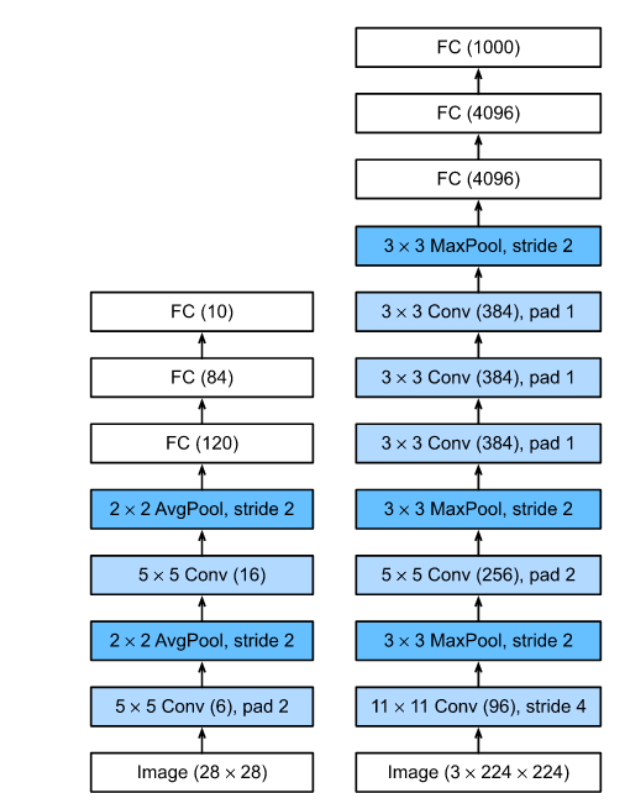

### AlexNet versus VGG



1. While previous derivatives of AlexNet focused on smaller window sizes and strides in the first convolutional layer, VGG addresses another very important aspect of CNNs: depth. 

2. Instead of using large receptive fields like AlexNet (11x11 with a stride of 4), VGG uses very small receptive fields (3x3 with a stride of 1). Because there are now three ReLU units instead of just one, the decision function is more discriminative. There are also fewer parameters (27 times the number of channels instead of AlexNet’s 49 times the number of channels).

3. VGG incorporates 1x1 convolutional layers to make the decision function more non-linear without changing the receptive fields. 

4. The small-size convolution filters allows VGG to have a large number of weight layers; of course, more layers leads to improved performance. This isn’t an uncommon feature, though. 

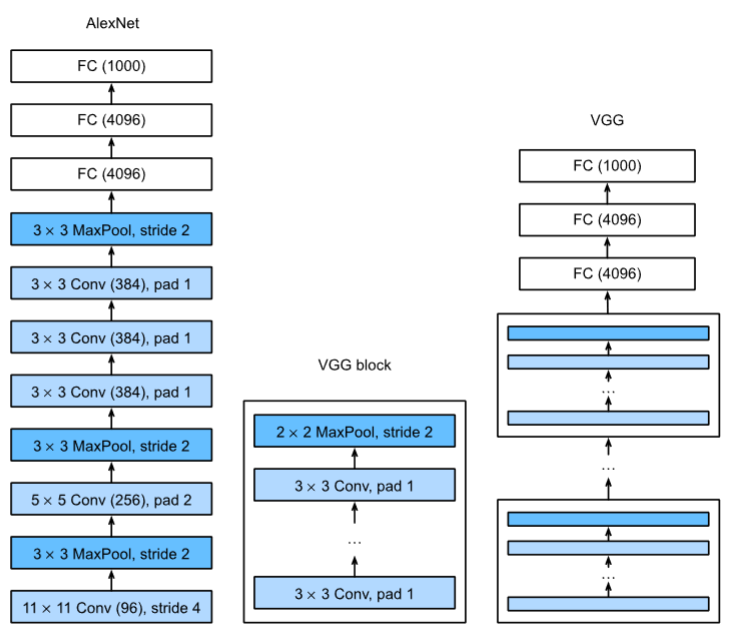

####################################################################################


## Apendix: different strategy for training 

Although AlexNet is trained on ImageNet in the paper, we use Fashion-MNIST here since training
an ImageNet model to convergence could take hours or days even on a modern GPU. One of the
problems with applying AlexNet directly on Fashion-MNIST is that its images have lower resolution
(28×28pixels) than ImageNet images. To make things work, we upsample them to 224×224
(generally not a smart practice, but we do it here to be faithful to the AlexNet architecture). We
perform this resizing with the resize argument in the d2l.load_data_fashion_mnist function.

In [ ]:
batch_size = 128

#(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

In [ ]:
import tensorflow as tf

class TrainCallback(tf.keras.callbacks.Callback): 
#"""A callback to visiualize the training progress."""
    def __init__(self, net, train_iter, test_iter, num_epochs, device_name):
        self.timer = d2l.Timer()
        self.animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                                     legend=['train loss', 'train acc', 'test acc'])
        self.net = net
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.num_epochs = num_epochs
        self.device_name = device_name

def on_epoch_begin(self, epoch, logs=None):
    self.timer.start()
    
def on_epoch_end(self, epoch, logs):
    self.timer.stop()
    test_acc = self.net.evaluate(self.test_iter, verbose=0,return_dict=True)['accuracy']
    metrics = (logs['loss'], logs['accuracy'], test_acc)
    self.animator.add(epoch + 1, metrics)
    if epoch == self.num_epochs - 1:
        batch_size = next(iter(self.train_iter))[0].shape[0]
        num_examples = batch_size * tf.data.experimental.cardinality(
            self.train_iter).numpy()
        print(f'loss {metrics[0]:.3f}, train acc {metrics[1]:.3f}, '
            f'test acc {metrics[2]:.3f}')
        print(f'{num_examples / self.timer.avg():.1f} examples/sec on '
            f'{str(self.device_name)}')    
def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer = tensorflow.keras.optimizers.SGD(learning_rate=lr)
        loss = tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = LeNet()
        net.summary()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callback = TrainCallback(net, train_iter, test_iter, num_epochs,device_name)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net

In [ ]:
lr, num_epochs = 0.9, 10
import tensorflow 

train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In the code below, we define a function called vgg_block to implement one VGG block.

In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(tf.keras.layers.Conv2D(num_channels, kernel_size=3,padding='same', activation='relu'))
        blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
        return blk

The convolutional part of the network connects several VGG blocks in succession. The following variable conv_arch consists of a list of tuples (one per block), where each contains two values: the number of convolutional layers and the number of output channels, which are precisely the arguments required to call the vgg_block function. The fully-connected part of the VGG network is identical to that covered in AlexNet.

In [ ]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

The following code implements VGG-11. This is a simple matter of executing a for-loop over
conv_arch.

In [ ]:
def vgg(conv_arch):
    net = tf.keras.models.Sequential()
    # The convulational part
    for (num_convs, num_channels) in conv_arch:
        net.add(vgg_block(num_convs, num_channels))
    # The fully-connected part
    net.add(
    tf.keras.models.Sequential([tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10)]))
    return net
net = vgg(conv_arch)

Next, we will construct a single-channel data example with a height and width of 224 to observe
the output shape of each layer.

In [ ]:
X = tf.random.uniform((1, 224, 224, 1))
for blk in net.layers:
    X = blk(X)
print(blk.__class__.__name__, 'output shape:\t', X.shape)

### Training and Evaluation

Since VGG-11 is more computationally-heavy than AlexNet we construct a network with a smaller
number of channels. This is more than suﬀicient for training on Fashion-MNIST.

In [ ]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
# Recall that this has to be a function that will be passed to
# `d2l.train_ch6()` so that model building/compiling need to be within
# `strategy.scope()` in order to utilize the CPU/GPU devices that we have
net = lambda: vgg(small_conv_arch)

Apart from using a slightly larger learning rate, the model training process is similar to that of
AlexNet

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())